In [11]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})

PATH_DATA = "../datasets/CYP/"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
features_shared = np.load(os.path.join("features", "shared_set_features_MACCS.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_MACCS.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_MACCS.npy"))

In [4]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return accuracy, mcc


In [8]:
def test_sizes_set(size_list, n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, active_fraction, out_path, isoform, labels, features, features_only, labels_validation, suffix):
    out_path = os.path.join(out_path, isoform)
    os.makedirs(out_path, exist_ok=True)
    n_bits = features.shape[1]
    model = generate_model(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, n_bits)
    results_test = []
    results_validation = []
    active_indices = np.where(labels == 1)[0]
    inactive_indices = np.where(labels == 0)[0]
    for size in size_list:
        n_actives = int(active_fraction*size)
        if n_actives > len(active_indices):
            n_actives = len(active_indices)
        n_inactives = size-n_actives
        selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
        selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
        selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
        train_data, test_data, train_labels, test_labels = train_test_split(features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in test:", np.sum(test_labels)/len(test_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels, epochs=10, verbose=0)
        predictions = model.predict(test_data)
        print(f"Metrics with size {size}, testing set")
        res_test = print_metrics(predictions, test_labels);
        results_test.append(res_test)
        print(f"Metrics with size {size}, validation set")
        predictions = model.predict(features_only)
        res_validation = print_metrics(predictions, labels_validation);
        results_validation.append(res_validation)
    results_test = np.array(results_test)
    results_validation = np.array(results_validation)
    labels = ["Acc.", "MCC"]
    f, ax = plt.subplots(figsize=(10,10))
    lines = ax.plot(sizes, results_test, "x-")
    ax.legend(lines, labels)
    ax.set_xticks(ticks=sizes)
    ax.set_xticklabels(sizes, rotation=90, fontsize=16);
    f.savefig(os.path.join(out_path, f"metrics_validation_evolution_{isoform}.png"), bbox_inches="tight", dpi=300)
    f, ax = plt.subplots(figsize=(10,10))
    lines = ax.plot(sizes, results_validation, "x-")
    ax.legend(lines, labels)
    ax.set_xticks(ticks=sizes)
    ax.set_xticklabels(sizes, rotation=90, fontsize=16);
    f.savefig(os.path.join(out_path, f"metrics_test_evolution_{isoform}.png"), bbox_inches="tight", dpi=300)

Proportion actives in test: 0.32 Proportion actives in train: 0.32
Metrics with size 100, testing set
NER: 0.632, Sensitivity or recall: 0.500, Specificity: 0.765, Precision: 0.500, Correctly calssified: 0.680, MCC: 0.265
Metrics with size 100, validation set
NER: 0.620, Sensitivity or recall: 0.537, Specificity: 0.702, Precision: 0.505, Correctly calssified: 0.643, MCC: 0.237
Proportion actives in test: 0.32 Proportion actives in train: 0.32
Metrics with size 300, testing set
NER: 0.749, Sensitivity or recall: 0.792, Specificity: 0.706, Precision: 0.559, Correctly calssified: 0.733, MCC: 0.466
Metrics with size 300, validation set
NER: 0.626, Sensitivity or recall: 0.633, Specificity: 0.619, Precision: 0.485, Correctly calssified: 0.624, MCC: 0.243
Proportion actives in test: 0.32 Proportion actives in train: 0.32
Metrics with size 500, testing set
NER: 0.701, Sensitivity or recall: 0.625, Specificity: 0.776, Precision: 0.568, Correctly calssified: 0.728, MCC: 0.392
Metrics with size 

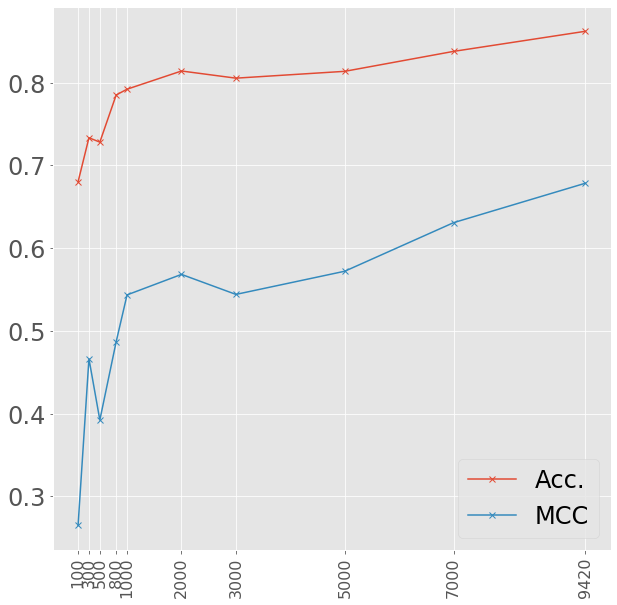

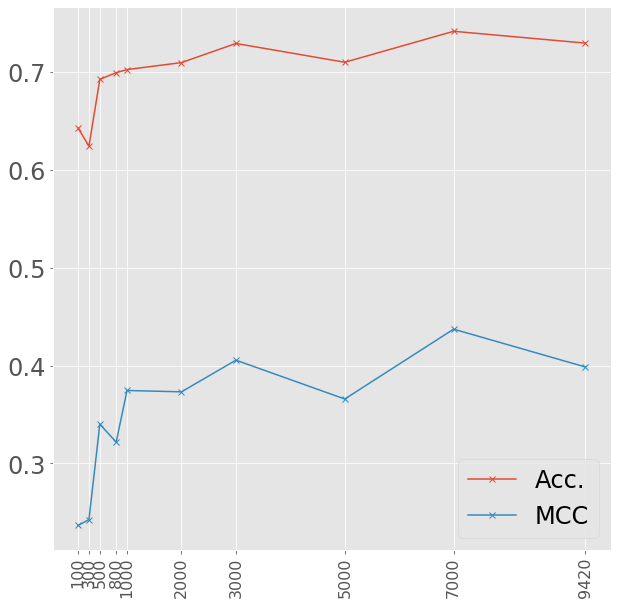

In [12]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001
sizes = [100, 300, 500, 800, 1000, 2000, 3000, 5000, 7000, 9420]
plots_path = "set_size_MACCS"
isoform_name = "2c9"
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
# non-balanced, 2c9 set
test_sizes_set(sizes, hidden_layers, neurons, dropout, opt, L2, active_rate, plots_path, isoform_name, labels_2c9, features_shared, features_only_2c9, labels_validation_2c9, "")

Proportion actives in test: 0.36 Proportion actives in train: 0.38666666666666666
Metrics with size 100, testing set
NER: 0.462, Sensitivity or recall: 0.111, Specificity: 0.812, Precision: 0.250, Correctly calssified: 0.560, MCC: -0.100
Metrics with size 100, validation set
NER: 0.535, Sensitivity or recall: 0.326, Specificity: 0.745, Precision: 0.551, Correctly calssified: 0.539, MCC: 0.078
Proportion actives in test: 0.38666666666666666 Proportion actives in train: 0.38666666666666666
Metrics with size 300, testing set
NER: 0.714, Sensitivity or recall: 0.690, Specificity: 0.739, Precision: 0.625, Correctly calssified: 0.720, MCC: 0.422
Metrics with size 300, validation set
NER: 0.638, Sensitivity or recall: 0.631, Specificity: 0.645, Precision: 0.631, Correctly calssified: 0.638, MCC: 0.276
Proportion actives in test: 0.384 Proportion actives in train: 0.38666666666666666
Metrics with size 500, testing set
NER: 0.679, Sensitivity or recall: 0.500, Specificity: 0.857, Precision: 0.6

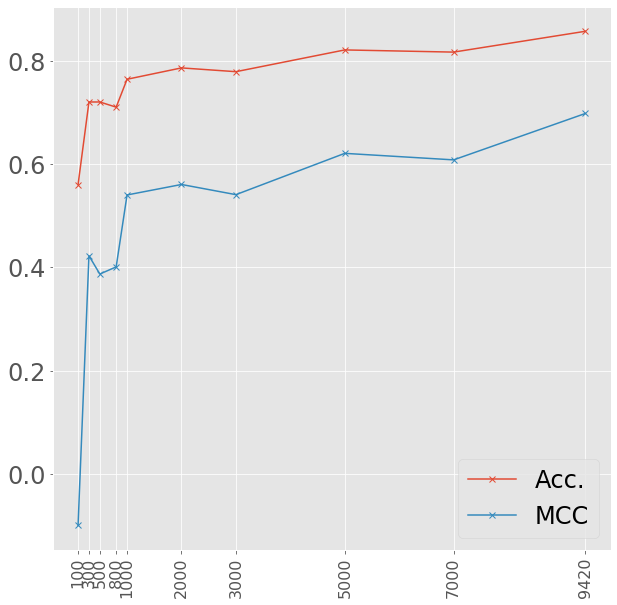

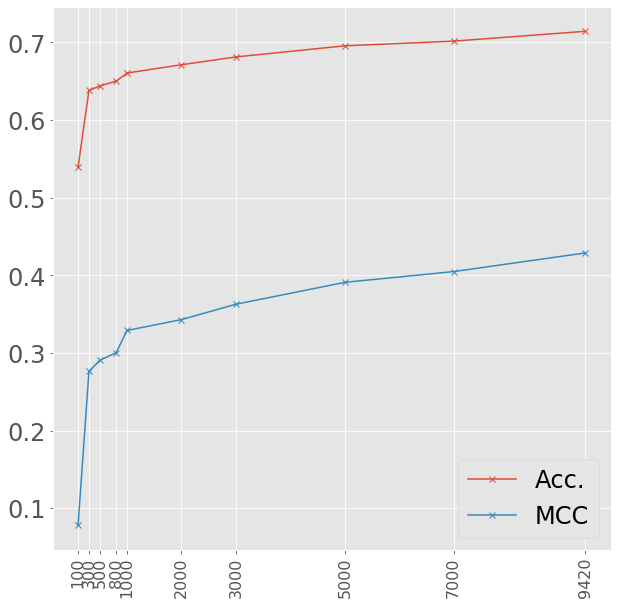

In [13]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001
sizes = [100, 300, 500, 800, 1000, 2000, 3000, 5000, 7000, 9420]
plots_path = "set_size_MACCS"
isoform_name = "3a4"
active_rate = len(np.where(labels_3a4 == 1)[0])/len(labels_3a4)
# non-balanced, 3a4 set
test_sizes_set(sizes, hidden_layers, neurons, dropout, opt, L2, active_rate, plots_path, isoform_name, labels_3a4, features_shared, features_only_3a4, labels_validation_3a4, "")